# **Regression pipeline**

## Read data

In [5]:
import os
import tarfile
import urllib

def fetch_housing_data(housing_url, housing_path):
    # Make the local directory
    os.makedirs(housing_path, exist_ok=True)    
    
    # Local dir/file name
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    
    # Retrieve tgz file
    urllib.request.urlretrieve(housing_url, tgz_path)    
    
    # Uncompress tgz file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

housing_path = os.path.join("datasets", "housing")
housing_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_url  = housing_root + "datasets/housing/housing.tgz"

fetch_housing_data(housing_url, housing_path)

In [6]:
csv_path = os.path.join(housing_path, "housing.csv")
housing  = pd.read_csv(csv_path)

## Split train-test

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

income_cat = pd.cut(housing["median_income"],
                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                    labels=[1, 2, 3, 4, 5])

In [12]:
for train_index, test_index in split.split(housing, income_cat):
    train = housing.loc[train_index]
    test  = housing.loc[test_index]
    
train.shape, test.shape

((16512, 10), (4128, 10))

## Identify numeric and categorical attributes

## Define label (y) and features (X)

In [32]:
y_train = train["median_house_value"]
X_train = train.drop("median_house_value", axis=1)
y_test  = test["median_house_value"]
X_test  = test.drop("median_house_value", axis=1)

In [46]:
X_train.shape

(16512, 9)

In [47]:
y_train.shape

(16512,)

In [48]:
housing_num = X_train.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

## Data processing and feature selection

### Processing pipelines

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Impute
    ('std_scaler', StandardScaler()),              # Normalize
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preproc_pipe = ColumnTransformer([
    ('num', num_pipe, num_attribs),
    ('cat', cat_pipe, cat_attribs),
])

### Pipeline with all steps

In [179]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

feat_pipe = Pipeline([
    ("preproc", preproc_pipe),
    ("select", SelectFromModel(LassoCV(), max_features=6)),
])

In [180]:
# Fit & transform data through the pipeline
X_train_feat = feat_pipe.fit_transform(X_train, y_train)
X_train.shape, X_train_feat.shape

((16512, 9), (16512, 6))

### Getting selected feature names

In [181]:
# Get indices of selected features
lasso    = feat_pipe["select"]

In [182]:
selected = lasso.get_support()
selected

array([ True,  True, False, False,  True,  True, False,  True, False,
        True, False, False, False])

In [183]:
# Get numeric feature name
#  last col from house is categorical
#  last second col is the label
num_feat_list = list(housing.columns)[:-2]
num_feat_list

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [184]:
# Get categorical feature names
step_preproc  = feat_pipe.named_steps["preproc"]
step_cat      = step_preproc.named_transformers_["cat"]
step_onehot   = step_cat.named_steps["onehot"]   
cat_feat_list = list(step_onehot.get_feature_names())
cat_feat_list

['x0_<1H OCEAN', 'x0_INLAND', 'x0_ISLAND', 'x0_NEAR BAY', 'x0_NEAR OCEAN']

Text(0.5, 0, 'Lasso weight')

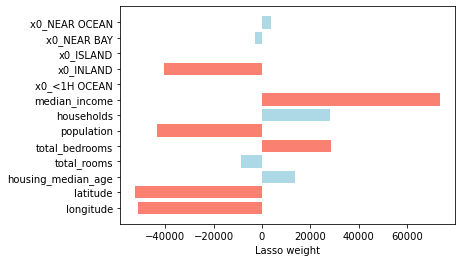

In [185]:
import matplotlib.pyplot as plt

all_feat = num_feat_list + cat_feat_list    # all features
fig, ax  = plt.subplots()
y_pos    = np.asarray(range(len(all_feat))) # For plotting y positions
coef     = lasso.estimator_.coef_           # Lasso feature weight coefficients

ax.barh(y_pos[selected], est.coef_[selected], color = 'salmon') 
ax.barh(y_pos[~selected], est.coef_[~selected], color = 'lightblue') 
ax.set_yticks(y_pos)
ax.set_yticklabels(all_feat)
ax.set_xlabel("Lasso weight")

In [186]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(10)
y = np.arange(10) * 0.1

mask1 = y < 0.5
mask2 = y >= 0.5
x[mask1]

array([0, 1, 2, 3, 4])

## Do hyperparameter tuning and cross-validation

### Fit model

In [187]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#from scipy.stats import randint

param_grid = {
    "n_estimators": randint(low=1, high=200), # use step name with "__" to specify
    "max_features": randint(low=1, high=8),}  # whcih step the parameters belong to

rf         = RandomForestRegressor()
rnd_search = RandomizedSearchCV(
    rf, param_distributions=param_grid, verbose=1,
    n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42,
    n_jobs=16)

rnd_search.fit(X_train_feat, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    9.9s finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=16,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023C5AB153C8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023C5AB15788>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

### Plot feature importance

Text(0.5, 0, 'Feature importance')

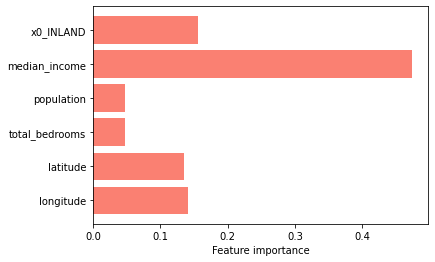

In [189]:
rf_best = rnd_search.best_estimator_   # best estimator
imp     = rf_best.feature_importances_ # Feature importance

fig, ax = plt.subplots()
y_pos   = np.asarray(range(X_train_feat.shape[1])) # For plotting y positions
selected_feat = np.asarray(all_feat)[selected]     # feature names

ax.barh(y_pos, imp, color = 'salmon')
ax.set_yticks(y_pos)
ax.set_yticklabels(selected_feat)
ax.set_xlabel("Feature importance")

### Access goodness-of-fit on training data

Text(0.5, 1.0, 'Training set')

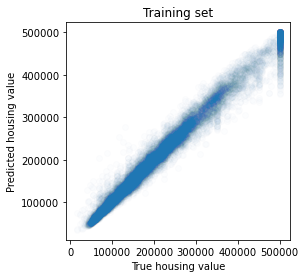

In [212]:
y_train_pred = rnd_search.predict(X_train_feat)

plt.figure(figsize=(4,4))
plt.scatter(y_train, y_train_pred, alpha=0.01)
plt.xlabel("True housing value")
plt.ylabel("Predicted housing value")
plt.title("Training set")

In [206]:
import scipy
scipy.stats.pearsonr(y_train, y_train_pred)[0]

0.9886020923988219

## Evalute model based on test data

### Transform test set

In [207]:
# Just transform, no fitting
X_test_feat = feat_pipe.transform(X_test)
X_test_feat.shape

(4128, 6)

### Apply model on the test set

In [208]:
y_test_pred = rnd_search.predict(X_test_feat)

Text(0.5, 1.0, 'Testing set')

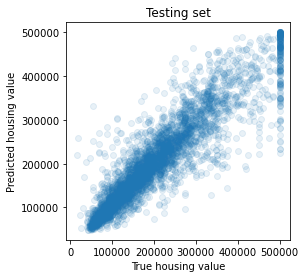

In [209]:
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.xlabel("True housing value")
plt.ylabel("Predicted housing value")
plt.title("Testing set")

In [211]:
# Goodness of fit
scipy.stats.pearsonr(y_test, y_pred)[0]

0.9126546902450553